## DESeq2 tutorial: Investigating differential gene expression across different carbon sources
In this tutorial, we will be using DESeq2 to investigate genes that are differntially expressed between 4 different carbon source conditions: glucose, fructoselysine, glucose+fructoselysine, and glucose+lysine. We will start with raw count data from the Wolf et al., 2019 Cell Host Microbe study (https://doi.org/10.1016/j.chom.2019.09.001), perform differential gene expression analysis, and visually explore some of the results.

### Import packages and load metadata

In [1]:
library("DESeq2")
packageVersion("DESeq2")

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The follow

[1] ‘1.30.1’

In [2]:
#Get metadata
map=read.table("Invitro_RNASeq_map.txt",sep="\t",header=T)
row.names(map)=map$Description
group=map$Treatment
#Peek at metadata
map

,Experiment,SampleID,Bacteria,Treatment,Plate,Well,RNASeq.prep.well,Description
,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
RNASeq1,Invitro,1,C. intestinalis,glucose,1,B2-5,A1,RNASeq1
RNASeq2,Invitro,2,C. intestinalis,glucose,1,C2-5,B1,RNASeq2
RNASeq3,Invitro,3,C. intestinalis,glucose,1,D2-5,C1,RNASeq3
RNASeq4,Invitro,4,C. intestinalis,fructoselysine,2,B2-5,D1,RNASeq4
RNASeq5,Invitro,5,C. intestinalis,fructoselysine,2,C2-5,E1,RNASeq5
RNASeq6,Invitro,6,C. intestinalis,fructoselysine,2,D2-5,F1,RNASeq6
RNASeq7,Invitro,7,C. intestinalis,glucose+fructoselysine,3,B2-5,G1,RNASeq7
RNASeq8,Invitro,8,C. intestinalis,glucose+fructoselysine,3,C2-5,H1,RNASeq8
RNASeq9,Invitro,9,C. intestinalis,glucose+fructoselysine,3,D2-5,A2,RNASeq9


Now let's import and subset data that has already been mapped to C. intestinalis genome to get columns that contain count data.

In [3]:
data=read.table(file = paste("Cint.normalized"),header=T,sep="\t")
row.names(data)=data$gene
counts=data[,grep("counts",colnames(data))]
colnames(counts)=unlist(lapply(strsplit(as.character(colnames(counts)),"\\."),function(x)x[2]))
counts.invitro=counts

In [6]:
#Peek at count data
counts.invitro[1:4,]

,RNASeq10,RNASeq11,RNASeq12,RNASeq1,RNASeq2,RNASeq3,RNASeq4,RNASeq5,RNASeq6,RNASeq7,RNASeq8,RNASeq9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
COLINT_01956,62,38,344,96,38,231,206,328,897,36,783,656
COLINT_01957,153,148,824,148,148,318,181,490,1827,36,1024,1066
COLINT_01958,501,193,637,209,107,257,385,818,1507,112,1025,921
COLINT_01959,259,183,855,151,302,344,409,359,1156,76,1277,1075


### Pre-filtering and formatting
In this step we will pre-filter genes that are not at least 40 counts in 4 samples. We will also fix our data to include only one bacterial species, C. intestinalis.

In [4]:
#counts as pre-processed include fractions so round, also remove pseudo count
tf=apply(counts.invitro,1,function(x)length(which(x>40))>4)
counts.invitro.adj=round(counts.invitro[tf,],digits = 0)-1
#fix map for just the one species
map.species=map[colnames(counts.invitro.adj),]
map.species=map.species[!is.na(map.species$Experiment),]
counts.invitro.adj=counts.invitro.adj[,row.names(map.species)]
#Peek at files
map.species  
head(counts.invitro.adj)

,Experiment,SampleID,Bacteria,Treatment,Plate,Well,RNASeq.prep.well,Description
,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
RNASeq10,Invitro,10,C. intestinalis,glucose+lysine,4,B2-5,B2,RNASeq10
RNASeq11,Invitro,11,C. intestinalis,glucose+lysine,4,C2-5,C2,RNASeq11
RNASeq12,Invitro,12,C. intestinalis,glucose+lysine,4,D2-5,D2,RNASeq12
RNASeq1,Invitro,1,C. intestinalis,glucose,1,B2-5,A1,RNASeq1
RNASeq2,Invitro,2,C. intestinalis,glucose,1,C2-5,B1,RNASeq2
RNASeq3,Invitro,3,C. intestinalis,glucose,1,D2-5,C1,RNASeq3
RNASeq4,Invitro,4,C. intestinalis,fructoselysine,2,B2-5,D1,RNASeq4
RNASeq5,Invitro,5,C. intestinalis,fructoselysine,2,C2-5,E1,RNASeq5
RNASeq6,Invitro,6,C. intestinalis,fructoselysine,2,D2-5,F1,RNASeq6


,RNASeq10,RNASeq11,RNASeq12,RNASeq1,RNASeq2,RNASeq3,RNASeq4,RNASeq5,RNASeq6,RNASeq7,RNASeq8,RNASeq9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
COLINT_01956,61,37,343,95,37,230,205,327,896,35,782,655
COLINT_01957,152,147,823,147,147,317,180,489,1826,35,1023,1065
COLINT_01958,500,192,636,208,106,256,384,817,1506,111,1024,920
COLINT_01959,258,182,854,150,301,343,408,358,1155,75,1276,1074
COLINT_01960,283,503,1548,35,228,560,231,460,1317,114,1194,1081
COLINT_01961,154,383,1195,127,306,682,203,341,1031,94,615,964


### Format data for DESeq2 and run DESeq analysis 
Here we will use the command DESeqDataSetFromMatrix to format our data to be interpretable to the DESeq program, and then run differential expression analysis on our data. Below we'll show the results of log2-fold changes in gene expression between two treatment conditions, glucose+lysine vs fructoselysine.

In [5]:
dds <- DESeqDataSetFromMatrix(countData = counts.invitro.adj, colData = map.species, design = ~Treatment)
dds

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



class: DESeqDataSet 
dim: 1570 12 
metadata(1): version
assays(1): counts
rownames(1570): COLINT_01956 COLINT_01957 ... COLINT_03794 COLINT_03795
rowData names(0):
colnames(12): RNASeq10 RNASeq11 ... RNASeq8 RNASeq9
colData names(8): Experiment SampleID ... RNASeq.prep.well Description

In [6]:
dds.deseq <- DESeq(dds)
deseq2.res <- results(dds.deseq, alpha = 0.05) #extract results from deseq2 analysis, optimizing for an FDR p.adj cutoff of 0.05
deseq2.res

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This 

log2 fold change (MLE): Treatment glucose.lysine vs fructoselysine 
Wald test p-value: Treatment glucose.lysine vs fructoselysine 
DataFrame with 1570 rows and 6 columns
              baseMean log2FoldChange     lfcSE      stat      pvalue
             <numeric>      <numeric> <numeric> <numeric>   <numeric>
COLINT_01956   194.018      -1.626159  0.482909 -3.367422 0.000758744
COLINT_01957   313.448      -0.622852  0.347055 -1.794679 0.072704834
COLINT_01958   462.514      -0.303613  0.552027 -0.549997 0.582321436
COLINT_01959   403.074      -0.356689  0.436670 -0.816839 0.414020600
COLINT_01960   446.379       0.687263  0.444001  1.547887 0.121649530
...                ...            ...       ...       ...         ...
COLINT_03791   611.354        2.14882  0.371745   5.78037 7.45381e-09
COLINT_03792   381.839        1.44236  0.381748   3.77831 1.57895e-04
COLINT_03793   229.300        1.79084  0.527258   3.39652 6.82477e-04
COLINT_03794  5579.152        1.27244  0.302312   4.20903 2.

In [10]:
summary(deseq2.res)


out of 1570 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 106, 6.8%
LFC < 0 (down)     : 116, 7.4%
outliers [1]       : 1, 0.064%
low counts [2]     : 0, 0%
(mean count < 16)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



### Analysis and visualization of results

The plot below shows the log2-fold changes for each gene for the above treatment comparison over the mean of the normalized counts across all samples.

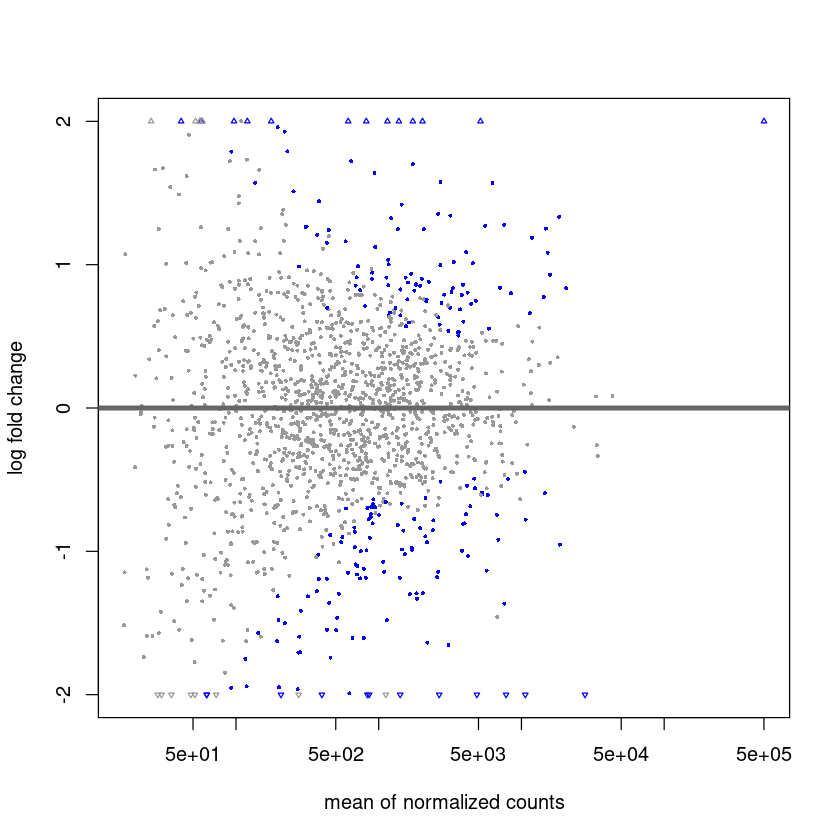

In [11]:
plotMA(deseq2.res, ylim=c(-2,2))

In [12]:
resultsNames(dds.deseq)

[1] "Intercept"                                         
[2] "Treatment_glucose_vs_fructoselysine"               
[3] "Treatment_glucose.fructoselysine_vs_fructoselysine"
[4] "Treatment_glucose.lysine_vs_fructoselysine"

In [13]:
BiocManager::install("apeglm")
library(apeglm)
#plotMA(resLFC, ylim=c(-2,2))

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://packagemanager.rstudio.com/all/__linux__/focal/latest


Bioconductor version 3.12 (BiocManager 1.30.16), R 4.0.5 (2021-03-31)

Installing package(s) 'apeglm'

also installing the dependencies ‘bdsmatrix’, ‘mvtnorm’, ‘bbmle’, ‘emdbook’, ‘RcppNumerical’


Installation paths not writeable, unable to update packages
  path: /usr/lib/R/site-library
  packages:
    littler

Old packages: 'phytools', 'plotly', 'poppr', 'tidyverse'



#### <ins>Log fold change shrinkage for visualization and ranking</ins>:
Shrinkage of LFC estimates is useful for visualization and ranking of genes, which remove the noise associated with log2 fold changes from low count genes without the need for arbitrary filters.

In [109]:
resLFC <- lfcShrink(dds.deseq, coef="Treatment_glucose.lysine_vs_fructoselysine")
resLFC

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



log2 fold change (MAP): Treatment glucose.lysine vs fructoselysine 
Wald test p-value: Treatment glucose.lysine vs fructoselysine 
DataFrame with 1570 rows and 5 columns
              baseMean log2FoldChange     lfcSE      pvalue        padj
             <numeric>      <numeric> <numeric>   <numeric>   <numeric>
COLINT_01956   194.018      -1.330968  0.525159 0.000758744  0.00930054
COLINT_01957   313.448      -0.430973  0.325610 0.072704834  0.24679024
COLINT_01958   462.514      -0.114717  0.345887 0.582321436  0.80594664
COLINT_01959   403.074      -0.177049  0.322997 0.414020600  0.68740563
COLINT_01960   446.379       0.383369  0.387472 0.121649530  0.33781967
...                ...            ...       ...         ...         ...
COLINT_03791   611.354        2.02378  0.382561 7.45381e-09 4.67801e-07
COLINT_03792   381.839        1.25189  0.403183 1.57895e-04 2.79491e-03
COLINT_03793   229.300        1.46477  0.580493 6.82477e-04 8.59080e-03
COLINT_03794  5579.152        1.14341 

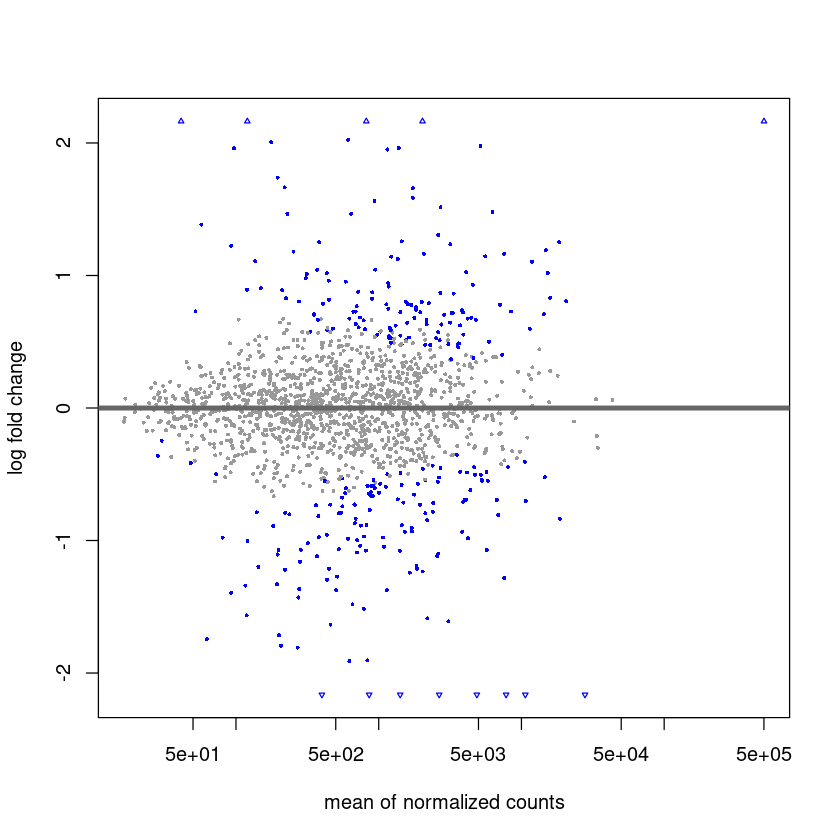

In [111]:
plotMA(resLFC)

#### <ins>Regularized logarithm transformation</ins>:
The *rlog* command uses experiment-wide trend of variance over mean, in order to transform the data to remove the experiment-wide trend. *rlog*  fits a model with a term for each sample and a prior distribution on the coefficients which is estimated from the data.

In [18]:
#Rlog transform
rld <- rlog(dds.deseq, blind=FALSE)

### Further visualizations of our results

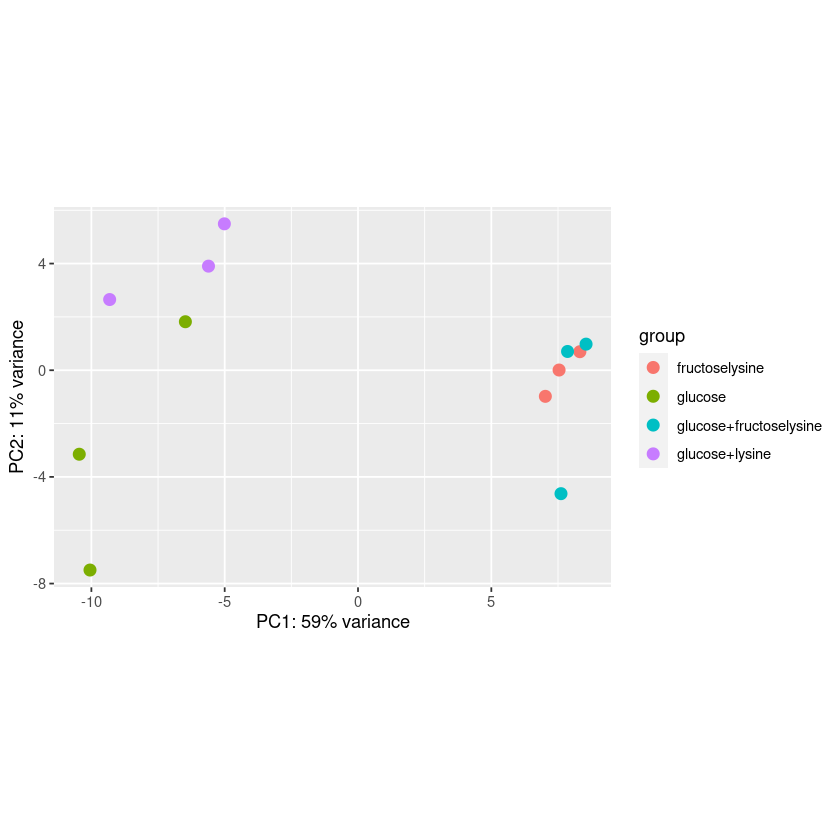

In [30]:
plotPCA(rld, intgroup=c("Treatment"))

In [19]:
select=row.names(deseq2.res)[deseq2.res$padj<.05]
select=select[!is.na(select)]
toplot.sig=assay(rld[select,])

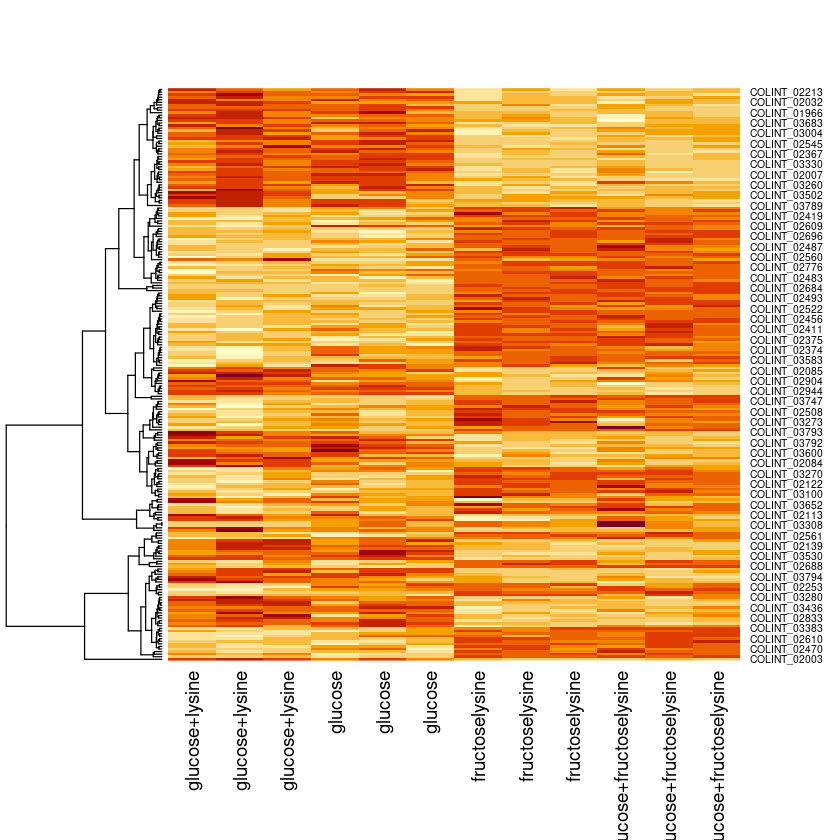

In [88]:
heatmap(toplot.sig, Colv = NA, Rowv = T, scale="row",labCol=map.species[colnames(toplot.sig),"Treatment"])

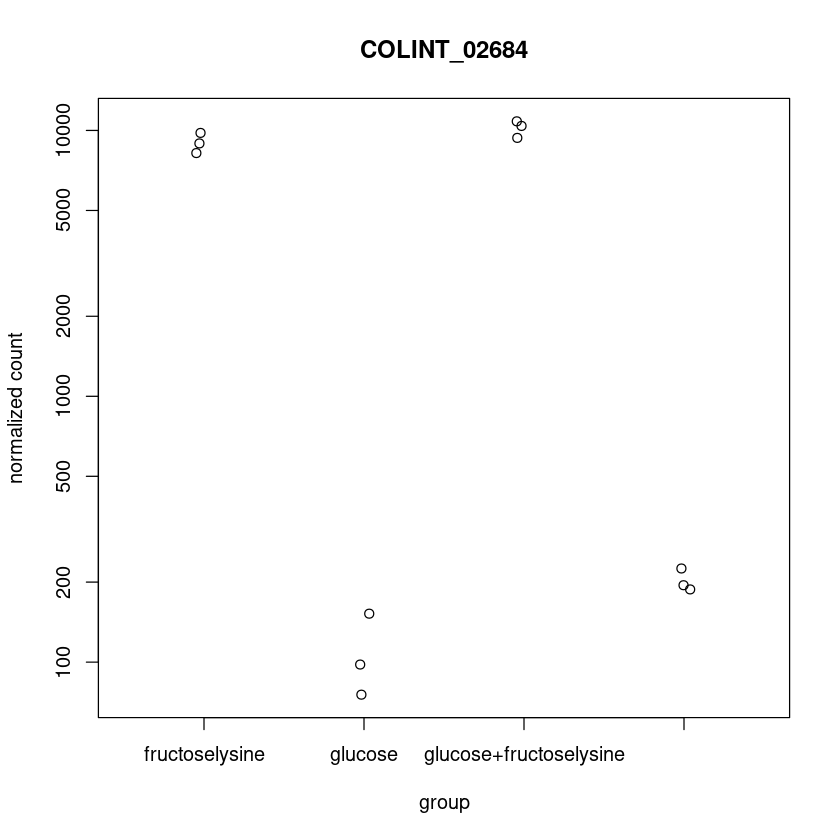

In [114]:
plotCounts(dds.deseq, gene=which.min(deseq2.res$padj), intgroup="Treatment")

Taking a closer look at the most highly significant genes: https://www.patricbrc.org/

In [16]:
deseq2.res.sig <- deseq2.res[order(deseq2.res$padj),]
head(deseq2.res.sig)

log2 fold change (MLE): Treatment glucose.lysine vs fructoselysine 
Wald test p-value: Treatment glucose.lysine vs fructoselysine 
DataFrame with 6 rows and 6 columns
              baseMean log2FoldChange     lfcSE      stat       pvalue
             <numeric>      <numeric> <numeric> <numeric>    <numeric>
COLINT_02684   4872.49       -5.48348  0.205939  -26.6267 3.33306e-156
COLINT_02685   7806.74       -4.64927  0.259075  -17.9456  5.19052e-72
COLINT_02699   2653.57       -4.16724  0.283517  -14.6984  6.60456e-49
COLINT_02688  27880.45       -2.39215  0.196193  -12.1928  3.39383e-34
COLINT_02687  10645.91       -2.45106  0.207506  -11.8120  3.38501e-32
COLINT_02682   1414.12       -3.40986  0.324994  -10.4921  9.39345e-26
                     padj
                <numeric>
COLINT_02684 5.22957e-153
COLINT_02685  4.07197e-69
COLINT_02699  3.45418e-46
COLINT_02688  1.33123e-31
COLINT_02687  1.06222e-29
COLINT_02682  2.45639e-23